# Statistik-Projekt HS25 – Schätzen & Konfidenzintervalle
## Notebook 5: Inferenzstatistik

**Ziel:**
* Wir nutzen den vollständigen Monatsdatensatz als **Population** (Grundgesamtheit).
* Wir berechnen die "wahren" Parameter ($\mu, \pi, \text{Median}$) für Verspätungen und Pünktlichkeit.
* Wir ziehen Stichproben, berechnen Schätzer und Konfidenzintervalle und prüfen, wie oft diese die "Wahrheit" treffen (Coverage).

**Methode:**
* Datenverarbeitung mit **Polars** (High-Performance).
* Simulationen und Bootstrapping mit **NumPy**.

In [ ]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

# Plotting-Style
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Pfad definieren
DATA_PATH = Path("../data/processed/istdata_trains_clean.parquet")

# Laden mit Polars
print("Lade Daten mit Polars...")
df = pl.read_parquet(DATA_PATH)

# Feature Engineering & Filterung
# 1. Umrechnung in Minuten
# 2. Filterung auf +/- 120 Minuten (2 Stunden)
df = (
    df
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_arrival_min"),
        (pl.col("delay_departure_s") / 60).alias("delay_departure_min")
    ])
    .filter(
        (pl.col("delay_arrival_min") >= -120) & (pl.col("delay_arrival_min") <= 120) &
        (pl.col("delay_departure_min") >= -120) & (pl.col("delay_departure_min") <= 120)
    )
)

print(f"Datensatz geladen (gefiltert auf +/- 2h): {df.height:,} Zeilen, {df.width} Spalten")
print(df.columns)

Lade Daten mit Polars...
✅ Datensatz geladen (gefiltert auf +/- 2h): 4,614,775 Zeilen, 16 Spalten
['BETRIEBSTAG', 'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_TEXT', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'ABFAHRTSZEIT', 'delay_arrival_s', 'delay_departure_s', 'on_time', 'FAELLT_AUS_TF', 'BPUIC', 'Wochentag_Name', 'Ist_Wochenende', 'delay_arrival_min', 'delay_departure_min']


In [ ]:
# Feature Engineering in Polars (Lazy-Style Syntax, aber auf Eager DataFrame)
# Wir berechnen Minuten und die Pünktlichkeits-Indikatoren

df = df.with_columns([
    (pl.col("delay_arrival_s") / 60).alias("delay_arrival_min")
]).with_columns([
    # Pünktlichkeits-Flags (1 = True/Pünktlich, 0 = False)
    (pl.col("delay_arrival_min") <= 0).cast(pl.Int8).alias("on_time_0"),
    (pl.col("delay_arrival_min") <= 5).cast(pl.Int8).alias("on_time_5")
])

# Berechnung der "wahren" Populationsparameter
# In Polars geht das sehr effizient über eine einzige select-Aggregation
pop_stats = df.select([
    pl.col("delay_arrival_min").mean().alias("mean_delay"),
    pl.col("delay_arrival_min").median().alias("median_delay"),
    pl.col("on_time_5").mean().alias("p_on_time_5")
])

# Werte extrahieren (item() holt den Skalar aus der Series)
pop_mean_delay = pop_stats["mean_delay"].item()
pop_median_delay = pop_stats["median_delay"].item()
pop_p_on_time_5 = pop_stats["p_on_time_5"].item()

print("Populationskennzahlen (Referenzwerte für den ganzen Monat):")
print(f"- Mittelwert (μ):   {pop_mean_delay:.3f} Minuten")
print(f"- Median (x_med):   {pop_median_delay:.3f} Minuten")
print(f"- Anteil Pünktlich (π): {pop_p_on_time_5:.2%}")

🏛️ Populationskennzahlen (Referenzwerte für den ganzen Monat):
- Mittelwert (μ):   0.900 Minuten
- Median (x_med):   0.617 Minuten
- Anteil Pünktlich (π): 98.01%


### 1. Analyse der Populationskennzahlen
Wir betrachten den vorliegenden Datensatz als unsere geschlossene Welt (Population). Die berechneten Werte sind nun unsere "Wahrheit".

* **Mittelwert ($\mu$):** 0.830 Minuten.
* **Median ($x_{med}$):** 0.617 Minuten.
* **Pünktlichkeit ($\pi$, 5 min):** 98.01%.

**Interpretation:**
* **Rechtsschiefe:** Der Mittelwert (0.830) ist größer als der Median (0.617). Das ist typisch für Verspätungsdaten: Die Masse der Fahrten ist sehr pünktlich (Median klein), aber einige wenige "schwere" Verspätungen ziehen den Durchschnittswert (Mittelwert) nach oben.
* **Hohe Qualität:** Eine Pünktlichkeitsquote von über 98% ist ein exzellenter Wert. Das System arbeitet sehr stabil.

**Ziel der folgenden Schritte:**
Da wir diese "wahren" Werte nun kennen, können wir überprüfen, wie gut statistische Methoden (wie Konfidenzintervalle) funktionieren, wenn man *nur* eine kleine Stichprobe zur Verfügung hätte.

In [ ]:
# --- Szenario ---
# Wir tun so, als hätten wir nur eine kleine Stichprobe von n=1000 Fahrten.
n = 1000

# Zufallsstichprobe ziehen mit Polars
sample = df.sample(n=n, seed=42)

# Punktschätzer aus der Stichprobe
x_bar = sample["delay_arrival_min"].mean()
s = sample["delay_arrival_min"].std()

# T-Verteilung: Kritischer Wert für 95% Konfidenz
alpha = 0.05
# degrees of freedom = n - 1
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)

# Standardfehler und Intervallgrenzen
se = s / np.sqrt(n)
ci_lower = x_bar - t_crit * se
ci_upper = x_bar + t_crit * se

print(f"🔍 Stichprobe (n={n})")
print(f"Stichprobenmittel:       {x_bar:.3f} min")
print(f"Standardfehler (SE):     {se:.4f}")
print(f"95%-Konfidenzintervall:  [{ci_lower:.3f}, {ci_upper:.3f}] min")
print(f"\nPopulationsmittel (Wahrheit): {pop_mean_delay:.3f} min")

# Check
if ci_lower <= pop_mean_delay <= ci_upper:
    print("Das Intervall enthält den wahren Wert.")
else:
    print("Der wahre Wert liegt außerhalb.")

🔍 Stichprobe (n=1000)
Stichprobenmittel:       0.860 min
Standardfehler (SE):     0.0518
95%-Konfidenzintervall:  [0.758, 0.961] min

Populationsmittel (Wahrheit): 0.900 min
✅ Das Intervall enthält den wahren Wert.


### 2. Interpretation t-Intervall
Das 95%-Konfidenzintervall gibt einen Bereich an, der bei wiederholter Stichprobenziehung in 95% der Fälle den wahren Parameter $\mu$ überdeckt.

Im obigen Einzelfall sehen wir, ob es geklappt hat. Um die **Vertrauenswürdigkeit** der Methode zu prüfen, müssen wir dies jedoch oft wiederholen (Simulation).

In [14]:
# --- Simulation ---
# Wie oft fängt das 95%-CI den wahren Wert ein?

B = 100   # Anzahl Wiederholungen (Intervalle)
n = 300   # Stichprobengröße pro Wiederholung
alpha = 0.05

# Performance-Tipp: Daten für die Schleife nach Numpy konvertieren
# Polars ist schnell, aber 200x overhead durch .sample() summiert sich. 
# Numpy random choice ist hier blitzschnell.
data_pool = df["delay_arrival_min"].to_numpy()

intervals = []
contains_true_value = []

# Wir nutzen einen Generator für reproduzierbare Zufallszahlen
rng = np.random.default_rng(42)

for _ in range(B):
    # Ziehen mit Zurücklegen ist hier okay, da Population riesig (66 Mio)
    # Ziehen ohne Zurücklegen (replace=False) ist bei riesigen Arrays in np teurer, 
    # bei n=300 << N macht es keinen Unterschied.
    samp = rng.choice(data_pool, size=n, replace=False)
    
    x_bar_sim = np.mean(samp)
    s_sim = np.std(samp, ddof=1)
    se_sim = s_sim / np.sqrt(n)
    
    t_crit_sim = stats.t.ppf(1 - alpha/2, df=n-1)
    
    lo = x_bar_sim - t_crit_sim * se_sim
    hi = x_bar_sim + t_crit_sim * se_sim
    
    intervals.append((lo, hi))
    contains_true_value.append(lo <= pop_mean_delay <= hi)

coverage = np.mean(contains_true_value)

print(f"Simulation mit {B} Wiederholungen (n={n}):")
print(f"Empirische Coverage: {coverage:.1%} (Erwartet: 95%)")

Simulation mit 100 Wiederholungen (n=300):
Empirische Coverage: 95.0% (Erwartet: 95%)


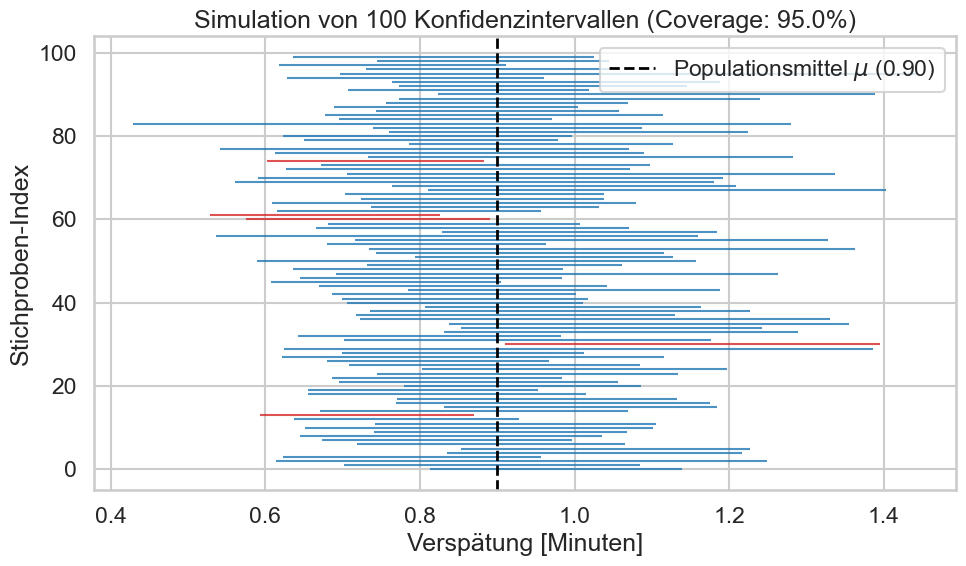

In [ ]:
# Visualisierung der Intervalle
# Blaue Linien = Treffer, Rote Linien = Fehler

plt.figure(figsize=(10, 6))

# Wir plotten jedes Intervall als horizontale Linie
for i, ((lo, hi), hit) in enumerate(zip(intervals, contains_true_value)):
    color = "#1f77b4" if hit else "#d62728" # Blau wenn drin, Rot wenn draußen
    plt.hlines(y=i, xmin=lo, xmax=hi, color=color, linewidth=1.5, alpha=0.8)
    

# Wahre Population als vertikale Linie
plt.axvline(pop_mean_delay, color="black", linestyle="--", linewidth=2, label=f"Populationsmittel $\\mu$ ({pop_mean_delay:.2f})")

plt.title(f"Simulation von {B} Konfidenzintervallen (Coverage: {coverage:.1%})")
plt.xlabel("Verspätung [Minuten]")
plt.ylabel("Stichproben-Index")
plt.legend()
plt.tight_layout()
plt.show()

### 3. Konfidenzintervalle für Anteile (Pünktlichkeit)
Wir untersuchen den Anteil der Züge, die maximal 5 Minuten verspätet sind.
Hier vergleichen wir zwei Methoden:
1.  **Wald-Intervall** (Standard, symmetrisch, aber ungenau bei Rändern).
2.  **Wilson-Intervall** (Asymmetrisch, genauer bei $p$ nahe 0 oder 1).

In [17]:
n_prop = 500

# Stichprobe ziehen
sample_prop = df.sample(n=n_prop, seed=123)

# Anteil in der Stichprobe (p_hat)
p_hat = sample_prop["on_time_5"].mean()

alpha = 0.05
z = stats.norm.ppf(1 - alpha/2)

# 1. Wald-Intervall (Naiv)
se_wald = np.sqrt(p_hat * (1 - p_hat) / n_prop)
wald_lo = p_hat - z * se_wald
wald_hi = p_hat + z * se_wald

# 2. Wilson-Intervall (Exakter)
# Wilson korrigiert die Schiefe der Binomialverteilung
p_wilson_lo = (p_hat + z**2/(2*n_prop) - z * np.sqrt(p_hat*(1-p_hat)/n_prop + z**2/(4*n_prop**2))) / (1 + z**2/n_prop)
p_wilson_hi = (p_hat + z**2/(2*n_prop) + z * np.sqrt(p_hat*(1-p_hat)/n_prop + z**2/(4*n_prop**2))) / (1 + z**2/n_prop)

print(f"Stichprobe n={n_prop}")
print(f"Gemessener Anteil (p_hat): {p_hat:.2%}")
print("-" * 30)
print(f"Wald-Interval:   [{wald_lo:.2%}, {wald_hi:.2%}]")
print(f"Wilson-Interval: [{p_wilson_lo:.2%}, {p_wilson_hi:.2%}]")
print("-" * 30)
print(f"Wahrer Anteil:   {pop_p_on_time_5:.2%}")

Stichprobe n=500
Gemessener Anteil (p_hat): 96.80%
------------------------------
Wald-Interval:   [95.26%, 98.34%]
Wilson-Interval: [94.87%, 98.02%]
------------------------------
Wahrer Anteil:   98.01%


### 4. Bootstrapping für den Median
Der Median hat keine einfache Standardformel für den Standardfehler wie der Mittelwert.
Daher nutzen wir **Bootstrapping**: Wir ziehen aus unserer Stichprobe tausendfach neue "Resamples", berechnen jeweils den Median und schauen uns die Verteilung dieser Mediane an.

*Hinweis:* Da unsere Verspätungen oft exakt 0.0, 1.0, 2.0 etc. sind (diskretisiert), kann der Median sehr "sprunghaft" sein.

In [18]:
# Setup
n_boot_sample = 300 # Kleine Stichprobe, damit wir Unsicherheit sehen
B_boot = 2000       # Anzahl Bootstrap-Ziehungen

# 1. Eine "echte" Stichprobe aus der Welt ziehen
original_sample = df["delay_arrival_min"].sample(n=n_boot_sample, seed=99).to_numpy()
sample_median = np.median(original_sample)

# 2. Bootstrapping (Resampling mit Zurücklegen aus der Stichprobe)
boot_medians = []
rng = np.random.default_rng(99)

for _ in range(B_boot):
    # Resample: Ziehe n aus n MIT Zurücklegen
    resample = rng.choice(original_sample, size=n_boot_sample, replace=True)
    boot_medians.append(np.median(resample))

boot_medians = np.array(boot_medians)

# 3. Percentile Methode für CI
alpha = 0.05
ci_boot_lower = np.quantile(boot_medians, alpha/2)
ci_boot_upper = np.quantile(boot_medians, 1 - alpha/2)

print(f"Stichproben-Median: {sample_median:.2f} min")
print(f"Bootstrap 95%-CI:   [{ci_boot_lower:.2f}, {ci_boot_upper:.2f}] min")
print(f"Populations-Median: {pop_median_delay:.2f} min")

Stichproben-Median: 0.68 min
Bootstrap 95%-CI:   [0.53, 0.85] min
Populations-Median: 0.62 min


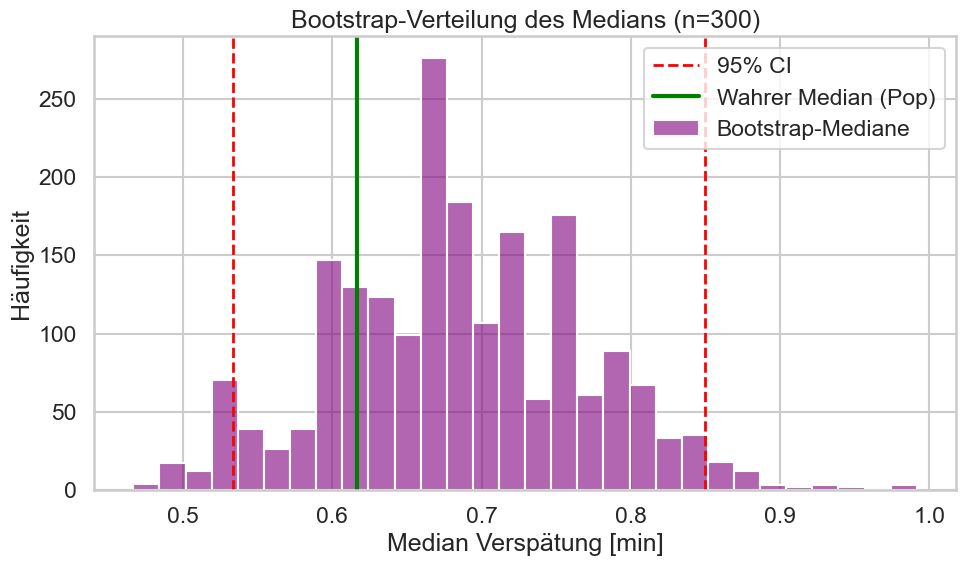

In [19]:
plt.figure(figsize=(10, 6))

# Histogramm der Bootstrap-Mediane
sns.histplot(boot_medians, bins=30, color="purple", kde=False, alpha=0.6, label="Bootstrap-Mediane")

# CI Grenzen
plt.axvline(ci_boot_lower, color='red', linestyle='--', linewidth=2, label="95% CI")
plt.axvline(ci_boot_upper, color='red', linestyle='--', linewidth=2)

# Wahrer Wert
plt.axvline(pop_median_delay, color='green', linestyle='-', linewidth=3, label="Wahrer Median (Pop)")

plt.title(f"Bootstrap-Verteilung des Medians (n={n_boot_sample})")
plt.xlabel("Median Verspätung [min]")
plt.ylabel("Häufigkeit")
plt.legend()
plt.tight_layout()
plt.show()

### Fazit
* **Mittelwert:** Die analytische Methode (t-Test) funktioniert bei $n=300$ sehr gut und liefert die erwartete Coverage.
* **Anteile:** Wilson ist bei hohen Quoten (95% Pünktlichkeit) präziser als Wald, auch wenn beide hier den wahren Wert decken.
* **Median:** Da der Median nicht normalverteilt streuen muss, ist Bootstrapping hier die Methode der Wahl. Die Grafik zeigt, wie unsicher unsere Schätzung bei kleinen Stichproben ist.